In [1]:
import cvxpy as cvx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
import matplotlib.animation as animation

## 1. Initialization of matrices and vectors

In [2]:
N_s = 50
N_obs = 15

np.random.seed(10)
A = np.random.randn(N_s, N_s)
C = np.random.randn(N_obs, N_s)
max_mod = abs(max(np.linalg.eig(A)[0]))
A = A * 0.98 / max_mod

B = np.random.randn(N_s, 5)
W = B @ B.T
V = np.identity(N_obs)
v0 = np.random.multivariate_normal(np.zeros(N_obs), V)
w0 = np.random.multivariate_normal(np.zeros(N_s), W)
prob_mask = np.random.choice([0, 1], p=[0.95, 0.05], size=N_obs)

time_steps = 10

In [3]:
x_array = []
y_array = []
v_array = []
w_array = []
x0 = np.random.randn(N_s)
x_array.append(x0)
y0 = v0 + (1 - prob_mask) * (C @ x0)
y_array.append(y0)
v_array.append(v0)
w_array.append(w0)
for _ in range(time_steps - 1):
    prob_mask = np.random.choice([0, 1], p=[0.95, 0.05], size=N_obs)
    v_curr = np.random.multivariate_normal(np.zeros(N_obs), V)
    w_curr = np.random.multivariate_normal(np.zeros(N_s), W)
    x_prev = x_array[-1]
    x_curr = A @ x_prev + w_curr
    y_curr = v_curr + (1 - prob_mask) * (C @ x_curr)
    
    x_array.append(x_curr)
    y_array.append(y_curr)
    v_array.append(v_curr)
    w_array.append(w_curr)

x_array = np.array(x_array)
y_array = np.array(y_array)

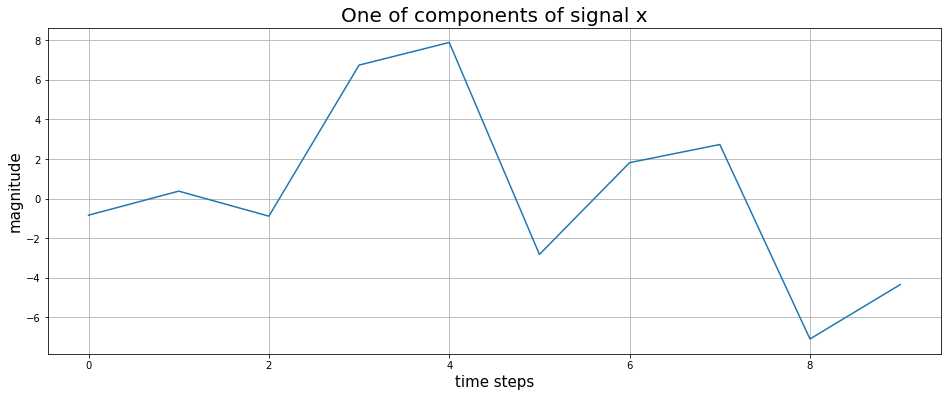

In [4]:
plt.figure(figsize=(16,6))
plt.title('One of components of signal x', fontsize=20)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(x_array[:, 0])

## 2.1 Standard Kalman filter (cvxpy solution)

100%|██████████| 9/9 [00:15<00:00,  2.07s/it]


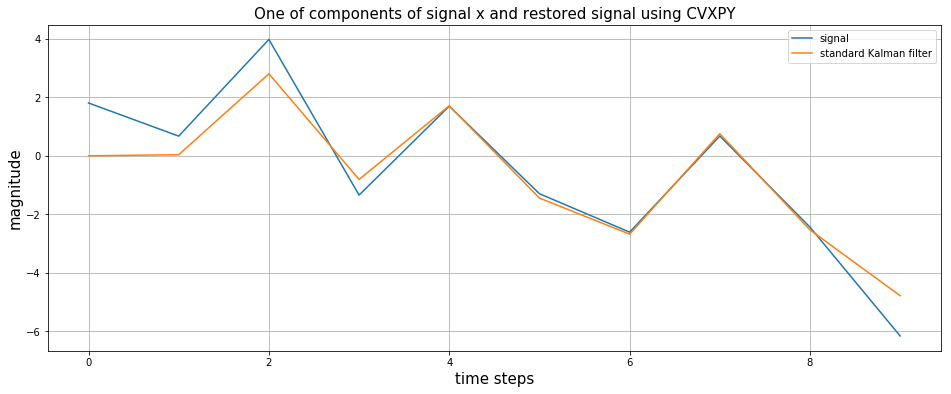

In [5]:
x_hat0 = np.zeros(N_s)
x_hat_array = np.array(x_hat0)
x_hat_array = x_hat_array.reshape((N_s,1))

sigma0 = np.identity(N_s)
sigma_array = np.array(sigma0)
sigma_array = sigma_array.reshape((N_s,N_s,1))

for i in tqdm(range(time_steps - 1)):
    # update steps
    x_hat_curr = x_hat_array[:,-1]
    sigma_curr = sigma_array[:,:,-1]
    x_hat_update = A @ x_hat_curr
    sigma_update = A @ sigma_curr @ A.T + W
    
    # formulate optimization problem
    x = cvx.Variable(N_s)
    v = cvx.Variable(N_obs)
    constraints = [y_array[i + 1] == C @ x + v]
    
    #P = np.linalg.inv(sigma_curr)
    P = np.linalg.inv(sigma_update)
    L = np.linalg.cholesky(P)
    objective = cvx.Minimize(cvx.norm(v)**2 + cvx.norm(L.T@(x - x_hat_update))**2)
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='SCS')

    x_hat_new = np.array(x.value)
    v_new = v.value
    
    x_hat_new = x_hat_new.reshape((N_s,1))
    x_hat_array = np.append(x_hat_array, x_hat_new, axis = 1)

    # for sigma the same
    #sigma_update = A @ sigma_curr @ A.T + W
    sigma_new = sigma_update  - sigma_update @ C.T @ np.linalg.inv(C @ sigma_update @ C.T + V) @ C @ sigma_update
    sigma_new = sigma_new.reshape((N_s,N_s,1))
    sigma_array = np.append(sigma_array, sigma_new, axis=2)

plt.figure(figsize=(16, 6))
plt.title('One of components of signal x and restored signal using CVXPY', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(x_array[:, 1], label='signal')
plt.plot(x_hat_array[1, :], label='standard Kalman filter')
plt.legend(loc='best')
plt.show()

## 2.2 Standard Kalman filter (analytical solution)

In [6]:
x_hat_array_an = []
x_hat0_an = np.zeros(N_s)
x_hat_array_an.append(x_hat0_an)

sigma_array_an = []
sigma0_an = np.identity(N_s)
sigma_array_an.append(sigma0_an)

In [7]:
for i in range(time_steps - 1):
    x_hat_curr_an = x_hat_array_an[-1]
    sigma_curr_an = sigma_array_an[-1]
    
    x_hat_update_an = A @ x_hat_curr_an
    sigma_update_an = A @ sigma_curr_an @ A.T + W
    #x_hat_new_an = x_hat_update_an + sigma_curr_an @ C.T @ np.linalg.inv(C @ sigma_curr_an @ C.T + V) @ (y_array[i + 1] - C @ x_hat_update_an)
    x_hat_new_an = x_hat_update_an + sigma_update_an @ C.T @ np.linalg.inv(C @ sigma_update_an @ C.T + V) @ (y_array[i + 1] - C @ x_hat_update_an)
    x_hat_array_an.append(x_hat_new_an)
    
    #sigma_update_an = A @ sigma_curr_an @ A.T + W
    sigma_new_an = sigma_update_an  - sigma_update_an @ C.T @ np.linalg.inv(C @ sigma_update_an @ C.T + V) @ C @ sigma_update_an
    sigma_array_an.append(sigma_new_an)

x_hat_array_an = np.array(x_hat_array_an)
sigma_array_an = np.array(sigma_array_an)

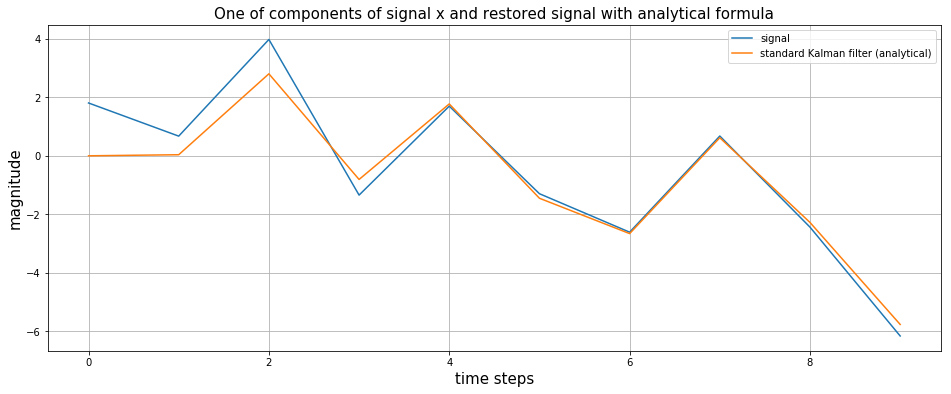

In [8]:
plt.figure(figsize=(16, 6))
plt.title('One of components of signal x and restored signal with analytical formula', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(x_array[:, 1], label='signal')
plt.plot(x_hat_array_an[:, 1], label='standard Kalman filter (analytical)')
plt.legend(loc='best')
plt.show()

## 2.3. Comparison of analytical and cvxpy solutions

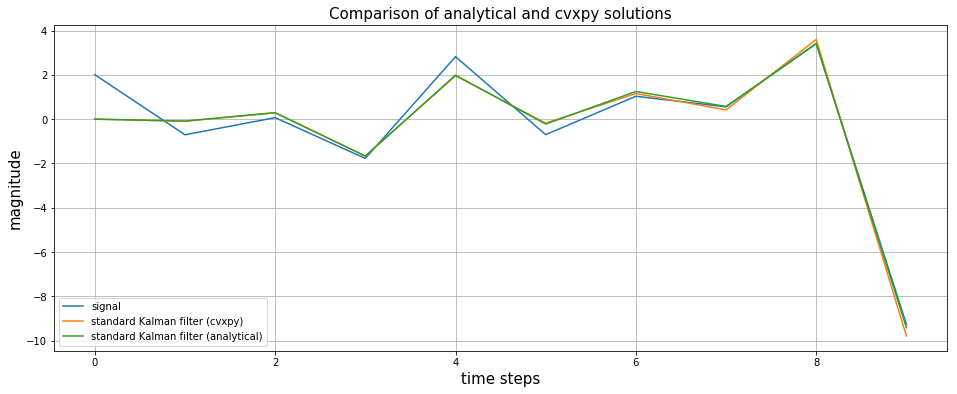

In [9]:
plt.figure(figsize=(16, 6))
plt.title('Comparison of analytical and cvxpy solutions', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(x_array[:, 10], label='signal')
plt.plot(x_hat_array[10,:], label='standard Kalman filter (cvxpy)')
plt.plot(x_hat_array_an[:, 10], label='standard Kalman filter (analytical)')
plt.legend(loc='best')
plt.show()

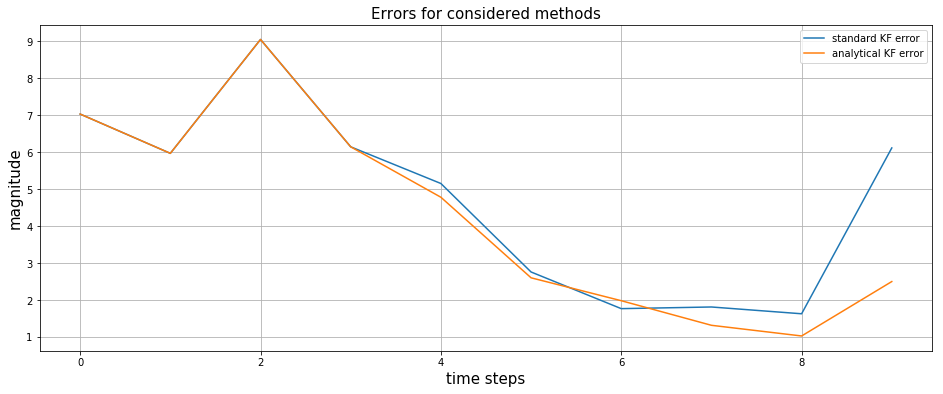

In [10]:
%matplotlib inline
fig = plt.figure(figsize=(16, 6))
plt.title('Errors for considered methods', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(np.linalg.norm(x_array.T-x_hat_array, axis=0), label='standard KF error')
plt.plot(np.linalg.norm(x_array.T-x_hat_array_an.T, axis=0), label='analytical KF error')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


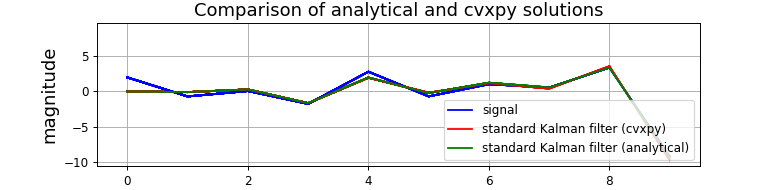

In [21]:
%matplotlib notebook
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=800)
slowdown_rate = 3

fig = plt.figure(figsize=(9, 2.2))
plt.xlim(-0.5, time_steps-0.5)
plt.ylim(np.min(x_array), np.max(x_array))
plt.title('Comparison of analytical and cvxpy solutions', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()


def animate(j):
    if j == 0:
        plt.legend()
    i = j // slowdown_rate   
    plt.plot(x_array[:i, 10], label='signal', c='b')
    plt.plot(x_hat_array[10,:i], label='standard Kalman filter (cvxpy)', c='r')
    plt.plot(x_hat_array_an[:i, 10], label='standard Kalman filter (analytical)', c='g')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=slowdown_rate*(time_steps+1), repeat=False)
#ani.save('Comparison_of_cvxpy_and_analytical_standard_Kalman.mp4', writer=writer)

<IPython.core.display.Javascript object>


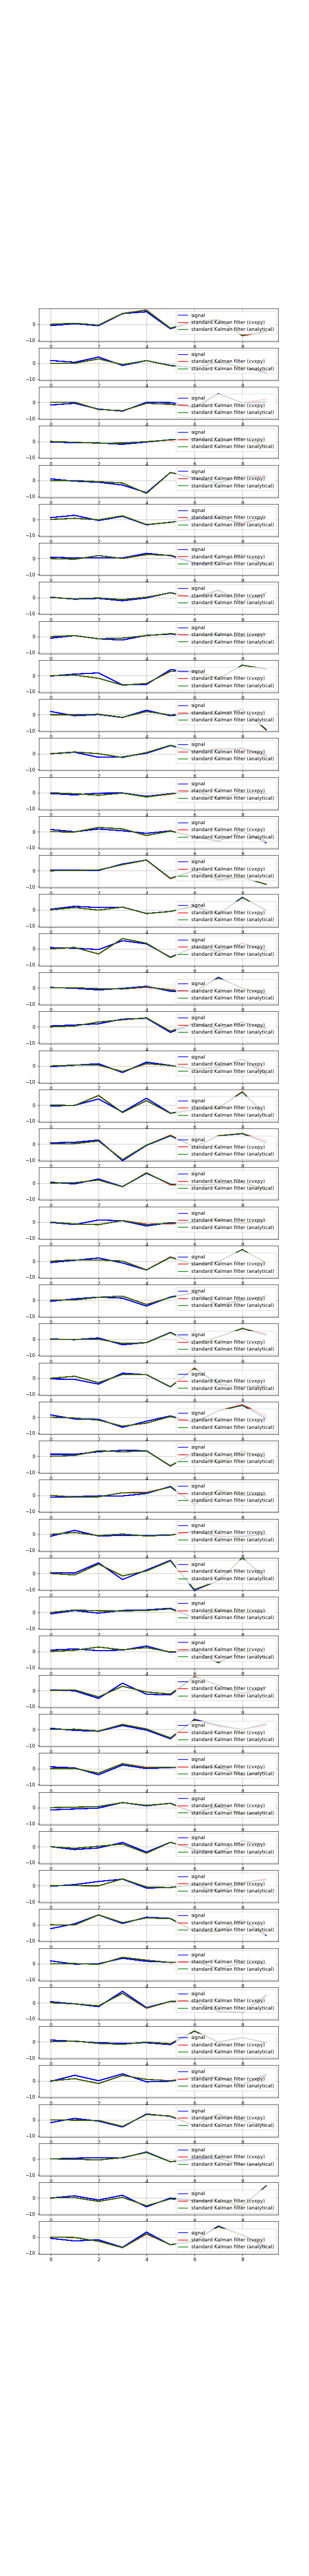

In [13]:
%matplotlib notebook
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=800)
slowdown_rate = 2
num_subplots = N_s 

fig = plt.figure(figsize=(9, N_s*1.5))
for splt in range(num_subplots):
    plt.subplot(num_subplots, 1, splt+1)
    plt.xlim(-0.5, time_steps-0.5)
    plt.ylim(np.min(x_array), np.max(x_array))
    #plt.title('Comparison of analytical and cvxpy solutions', fontsize=15)
    #plt.xlabel('time steps', fontsize=15)
    #plt.ylabel('magnitude', fontsize=15)
    plt.grid()

def animate(j):
    
    i = j // slowdown_rate   
    
    for splt in range(num_subplots):
        plt.subplot(num_subplots, 1, splt+1)
        if j == 0:
            plt.legend()
        plt.plot(x_array[:i, splt], label='signal', c='b')
        plt.plot(x_hat_array[splt,:i], label='standard Kalman filter (cvxpy)', c='r')
        plt.plot(x_hat_array_an[:i, splt], label='standard Kalman filter (analytical)', c='g')
    
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=slowdown_rate*(time_steps+1), repeat=False)
#ani.save('Comparison_of_cvxpy_and_analytical_standard_Kalman.mp4', writer=writer)

In [11]:
np.linalg.norm(x_hat_array_an - x_array)/np.linalg.norm(x_array)

0.22383159805479705

In [12]:
np.linalg.norm(x_hat_array.T - x_array)/np.linalg.norm(x_array)

0.2404251398259925

In [13]:
np.linalg.norm(x_hat_array.T - x_array)/np.linalg.norm(x_hat_array_an - x_array)

1.074134045038329

## 3. Robust Kalman filter

In [72]:
lam_array = np.array([2])#np.linspace(0.4, 0.43, num = 1)

for lam in lam_array:
    
    x_hat0_robust = np.zeros(N_s)
    x_hat_robust_array = np.array(x_hat0_robust)
    x_hat_robust_array = x_hat_robust_array.reshape((N_s,1))

    sigma0_robust = np.identity(N_s)
    sigma_robust_array = np.array(sigma0_robust)
    sigma_robust_array = sigma_robust_array.reshape((N_s,N_s,1))

    for i in tqdm(range(time_steps - 1)):
        # update steps
        x_hat_curr_robust = x_hat_robust_array[:,-1]
        sigma_curr_robust = sigma_robust_array[:,:,-1]

        x_hat_update_robust = A @ x_hat_curr_robust
        sigma_update_robust = A @ sigma_curr_robust @ A.T + W

        # formulate optimization problem
        x = cvx.Variable(N_s)
        v = cvx.Variable(N_obs)
        z = cvx.Variable(N_obs)
        t = cvx.Variable(N_obs)
        constraints = [y_array[i + 1] == C @ x + v + z,
                       lam*z <= t,
                       lam*z >=-t]

        P = np.linalg.inv(sigma_update_robust)
        L = np.linalg.cholesky(P)

        objective = cvx.Minimize(cvx.norm(v)**2 + cvx.norm(L.T @ (x - x_hat_update_robust))**2 + cvx.sum(t))
        problem = cvx.Problem(objective, constraints)
        problem.solve(solver='ECOS')
        x_hat_new_robust = x.value
        v_new = v.value
        z_new = z.value

        x_hat_new_robust = x_hat_new_robust.reshape((N_s,1))
        x_hat_robust_array = np.append(x_hat_robust_array, x_hat_new_robust, axis = 1)

        # for sigma the same
        #sigma_update_robust = A @ sigma_curr_robust @ A.T + W
        sigma_new_robust = sigma_update_robust  - sigma_update_robust @ C.T @ np.linalg.inv(C @ sigma_update_robust @ C.T + V) @ C @ sigma_update_robust
        sigma_new_robust = sigma_new_robust.reshape((N_s,N_s,1))
        sigma_robust_array = np.append(sigma_robust_array, sigma_new_robust, axis=2)

    print('lam = ', lam)
    print('error = ', np.linalg.norm(x_hat_robust_array.T-x_array))
    print('z = ', z.value)
    print('Non-zero elements in z:', N_obs - np.sum(np.round(z.value,1) == 0))
    nzv = N_obs - np.sum(np.round(z.value,1) == 0)
    if nzv > 0 and nzv < 3:
        break



  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:00<00:00,  9.21it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.25it/s]

 44%|████▍     | 4/9 [00:00<00:00, 10.29it/s]

 56%|█████▌    | 5/9 [00:00<00:00,  9.82it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.78it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.64it/s]

100%|██████████| 9/9 [00:00<00:00, 10.91it/s]

lam =  2
error =  13.928762623717857
z =  [-2.77559536e-08 -1.53808029e-08 -6.06561104e-08  3.18512578e-08
 -8.07094454e-09  4.25101516e-08 -3.35631064e-08 -1.27753694e-09
 -5.17332954e-09  4.15055382e-08  1.47661894e+00  7.37693077e+00
 -1.06370959e-08 -2.43698648e-08 -5.10383216e-08]
Non-zero elements in z: 2


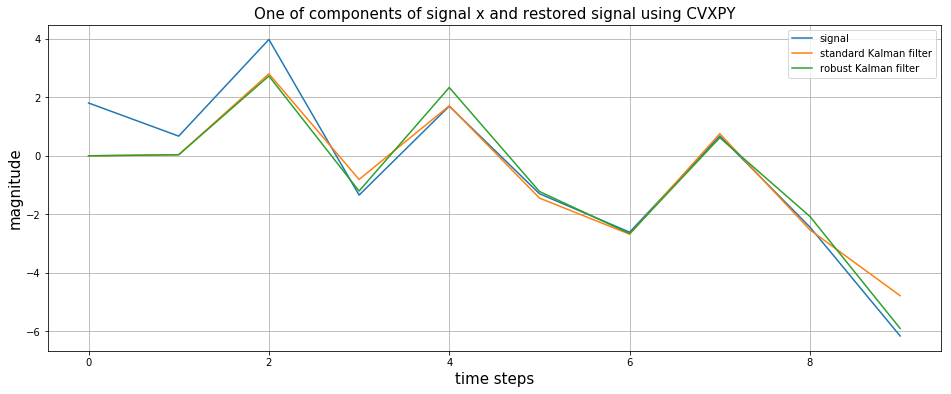

In [73]:
%matplotlib inline
fig = plt.figure(figsize=(16, 6))
plt.title('One of components of signal x and restored signal using CVXPY', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(x_array[:, 1], label='signal')
plt.plot(x_hat_array[1, :], label='standard Kalman filter')
plt.plot(x_hat_robust_array[1, :], label='robust Kalman filter')
plt.legend(loc='best')
plt.show()

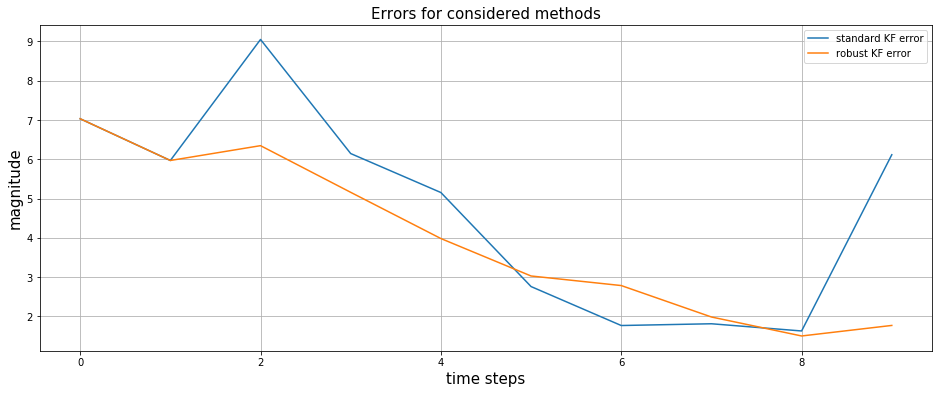

In [74]:
%matplotlib inline
fig = plt.figure(figsize=(16, 6))
plt.title('Errors for considered methods', fontsize=15)
plt.xlabel('time steps', fontsize=15)
plt.ylabel('magnitude', fontsize=15)
plt.grid()
plt.plot(np.linalg.norm(x_array.T-x_hat_array, axis=0), label='standard KF error')
plt.plot(np.linalg.norm(x_array.T-x_hat_robust_array, axis=0), label='robust KF error')
plt.legend(loc='best')
plt.show()